In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
PERFORMANCE_DATA_DIR = os.path.expanduser("../../data/processed/Performance/")
NAME_FOR_MODEL = "X-CRISP\n"
COMMON_ORDER_OF_MODELS = [NAME_FOR_MODEL + "KLD", NAME_FOR_MODEL + "MSE", "FORECasT", "Lindel", "inDelphi", "CROTON"]
print(os.listdir(PERFORMANCE_DATA_DIR))
sns.set_context("paper")

['precision-X-f1_score.tsv', 'stats_comparison_corr.tsv', 'precision-X-mcc.tsv', 'stats_comparison.tsv', 'precision-X-recall.tsv', 'insertion.tsv', 'precision-X-prec.tsv', '.gitkeep', 'overall.tsv', 'mhless.tsv', 'bad1bpins', 'mh.tsv']


In [4]:
OUTPUT_DIR = os.environ['OUTPUT_DIR']
INPUT_F = OUTPUT_DIR + "/model_training/data_100x/X-CRISP/{}.pkl" 

def load_data(dataset = "train", num_samples = None, fractions=True):
    datafile = INPUT_F.format(dataset)
    print(datafile)
    data = pd.read_pickle(INPUT_F.format(dataset))
    del_features = data["del_features"]
    counts = data["counts"]
    samples = counts.index.levels[0]
    return counts, samples, del_features

def count_MH_vs_MHless(counts, features):
    d = features.join(counts, how="inner")[["homologyLength", "countEvents"]]
    d["homology"] = d["homologyLength"] > 0
    a = d[["homology", "countEvents"]].groupby(["homology"]).sum()
    return a/a.sum()

WT, _, WT_features = load_data(dataset="0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1", num_samples=None)
U2OS, _, U2OS_features = load_data(dataset="052218-U2OS-+-LibA-postCas9-rep1_test", num_samples=None)
NHEJ, _, NHEJ_features = load_data(dataset="0226-PRLmESC-Lib1-Cas9_test", num_samples=None)
HAP1, _, HAP1_features = load_data(dataset="HAP1_test", num_samples=None)
TREX, _, TREX_features = load_data(dataset="TREX_A_test", num_samples=None)
test, _, test_features = load_data(dataset="test", num_samples=None)
train, _, train_features = load_data(dataset="train", num_samples=None)
FORECasT_counts = pd.concat([train, test])
FORECasT_features = pd.concat([train_features, test_features])

/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/0105-mESC-Lib1-Cas9-Tol2-BioRep2-techrep1.pkl
/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/052218-U2OS-+-LibA-postCas9-rep1_test.pkl
/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/0226-PRLmESC-Lib1-Cas9_test.pkl
/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/HAP1_test.pkl
/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/TREX_A_test.pkl
/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/test.pkl
/Users/colm/repos/output/local//model_training/data_100x/X-CRISP/train.pkl


In [5]:
mESC_WT_FORECasT = pd.concat([test, train])

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/1997150700.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  WT_indel = WT.reset_index().groupby(["Indel", "Type"]).sum().drop("fraction", axis=1)


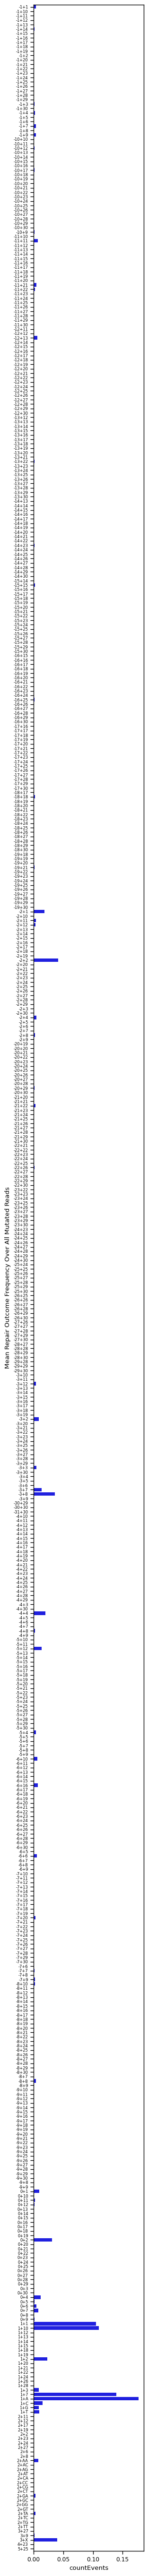

In [6]:
WT_indel = WT.reset_index().groupby(["Indel", "Type"]).sum().drop("fraction", axis=1)
WT_indel["countEvents"] = WT_indel["countEvents"]/WT_indel["countEvents"].sum()

fig, ax = plt.subplots(figsize=(3, 70))

b = sns.barplot(x="countEvents", y="Indel", data=WT_indel.reset_index(), color="b", ax=ax)
b.set_yticklabels(b.get_yticklabels(), size = 6)
b.set_ylabel("Mean Repair Outcome Frequency Over All Mutated Reads")
plt.show()

In [7]:
print("FORECasT mESC WT (Train)", len(train.index.get_level_values(0).unique()))
print("FORECasT mESC WT (Test)", len(test.index.get_level_values(0).unique()))
print("inDelphi mESC WT (Test)", len(WT.index.get_level_values(0).unique()))
print("inDelphi U2OS WT (Test)", len(U2OS.index.get_level_values(0).unique()))
print("inDelphi mESC -NHEJ", len(NHEJ.index.get_level_values(0).unique()))
print("FORECasT HAP1 WT (Test)", len(HAP1.index.get_level_values(0).unique()))
print("FORECasT TREX WT (Test)", len(TREX.index.get_level_values(0).unique()))

FORECasT mESC WT (Train) 5952
FORECasT mESC WT (Test) 3981
inDelphi mESC WT (Test) 5
inDelphi U2OS WT (Test) 383
inDelphi mESC -NHEJ 395
FORECasT HAP1 WT (Test) 4045
FORECasT TREX WT (Test) 3446


322 469


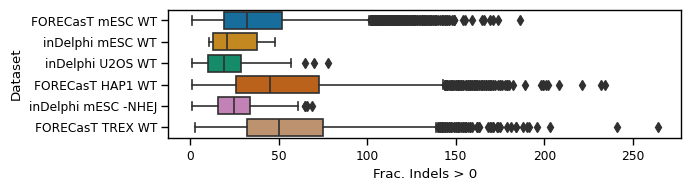

In [8]:
def plot_sparsity(counts, labels):
    lower_fraction = 0
    column_name = "Frac. Indels > {}".format(lower_fraction)
    results = []
    min_v = 100000
    max_v = 0
    for i, c in enumerate(counts):
        a = c[["fraction"]] > lower_fraction
        b = a.groupby(["Sample_Name"]).count()["fraction"]
        a = a.groupby(["Sample_Name"]).sum()
        a["Dataset"] = labels[i]
        results.append(a)
        max_v = b.max() if b.max() > max_v else max_v
        min_v = b.min() if b.min() < min_v else min_v
    print(min_v, max_v)
    r = pd.concat(results)
    r = r.reset_index()
    r = r.rename(columns={"fraction": column_name})
    return sns.boxplot(data=r, x=column_name, y="Dataset", palette="colorblind"), min_v, max_v
    
plt.figure(figsize=(7, 2))


sparsity_p, min_v, max_v = plot_sparsity([FORECasT_counts,\
    WT,\
    U2OS,\
    HAP1,\
    NHEJ,\
    TREX],\
    ["FORECasT mESC WT", "inDelphi mESC WT", "inDelphi U2OS WT",\
    "FORECasT HAP1 WT", "inDelphi mESC -NHEJ", "FORECasT TREX WT"])
# plt.axvline(min_v)
plt.tight_layout()

In [9]:
def get_ratios_of_homology_based_deletions(counts, features, title=""):
    d = features.join(counts, how="inner")[["homologyLength", "countEvents"]].reset_index()
    d["homologyLength"] = d["homologyLength"] > 0
    mh_totals = d[d["homologyLength"]][["Sample_Name", "countEvents"]].groupby("Sample_Name").sum()
    totals = d[["Sample_Name", "countEvents"]].groupby("Sample_Name").sum()
    ratios = mh_totals/totals
    x = ratios.reset_index()
    x["Dataset"] = title
    return x

homolen_datasets = []
homolen_datasets.append(get_ratios_of_homology_based_deletions(FORECasT_counts, FORECasT_features, title="FORECasT mESC WT"))
homolen_datasets.append(get_ratios_of_homology_based_deletions(WT, WT_features, title="inDelphi mESC WT"))
homolen_datasets.append(get_ratios_of_homology_based_deletions(U2OS, U2OS_features, title="inDelphi U2OS WT"))
homolen_datasets.append(get_ratios_of_homology_based_deletions(HAP1, HAP1_features, title="FORECasT HAP1 WT"))
homolen_datasets.append(get_ratios_of_homology_based_deletions(NHEJ, NHEJ_features, title="inDelphi mESC -NHEJ"))
homolen_datasets.append(get_ratios_of_homology_based_deletions(TREX, TREX_features, title="FORECasT TREX WT"))

homolen_datasets = pd.concat(homolen_datasets)

def get_ratios_of_ins_to_deletions(counts, title=""):
    counts = counts.groupby(["Sample_Name", "Type"]).sum()[["fraction"]].xs("DELETION", level=1).rename(columns={"fraction": "Fraction of Deletions"})
    counts["Dataset"] = title
    return counts
ins_datasets = []
ins_datasets.append(get_ratios_of_ins_to_deletions(FORECasT_counts, title="FORECasT mESC WT"))
ins_datasets.append(get_ratios_of_ins_to_deletions(WT, title="inDelphi mESC WT"))
ins_datasets.append(get_ratios_of_ins_to_deletions(U2OS, title="inDelphi U2OS WT"))
ins_datasets.append(get_ratios_of_ins_to_deletions(HAP1, title="FORECasT HAP1 WT"))
ins_datasets.append(get_ratios_of_ins_to_deletions(NHEJ, title="inDelphi mESC -NHEJ"))
ins_datasets.append(get_ratios_of_ins_to_deletions(TREX, title="FORECasT TREX WT"))

ins_datasets = pd.concat(ins_datasets)
ins2 = ins_datasets.reset_index().set_index(["Dataset", "Sample_Name"])
h2 = homolen_datasets.set_index(["Dataset", "Sample_Name"]).rename(columns={"countEvents": "Fraction of MH Deletions"})
scatterplot_d = ins2.join(h2, how="inner", on=["Dataset", "Sample_Name"]).reset_index()

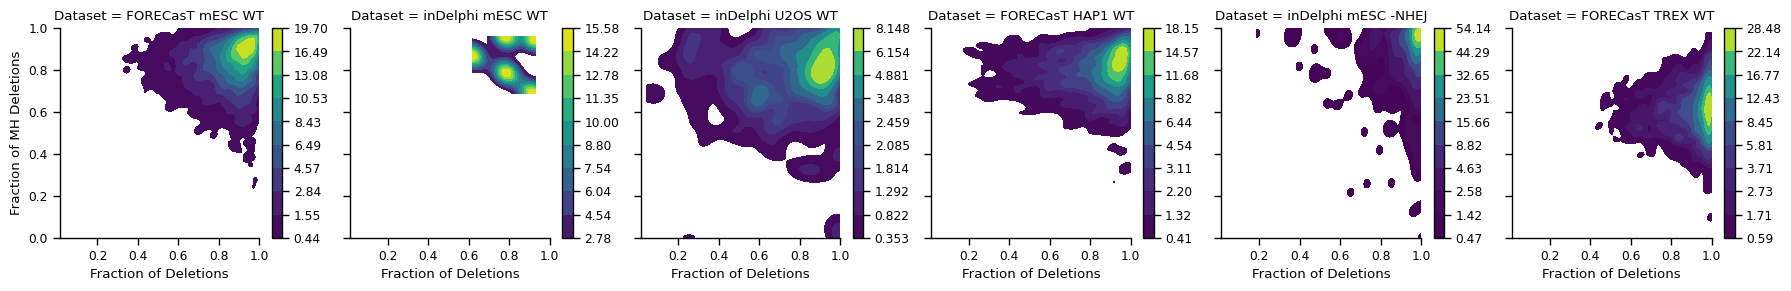

In [10]:
ratio_p = sns.FacetGrid(scatterplot_d, col="Dataset")
ratio_p.map_dataframe(sns.kdeplot, x="Fraction of Deletions", y="Fraction of MH Deletions", fill=True, cut=0, bw_adjust=0.5,\
    cbar=True, cmap="viridis")
axes = ratio_p.axes[0]
for a in axes:
    a.set_xlabel("Fraction of Deletions")
axes[0].set_ylabel("Fraction of MH Deletions")
ratio_p.tight_layout()

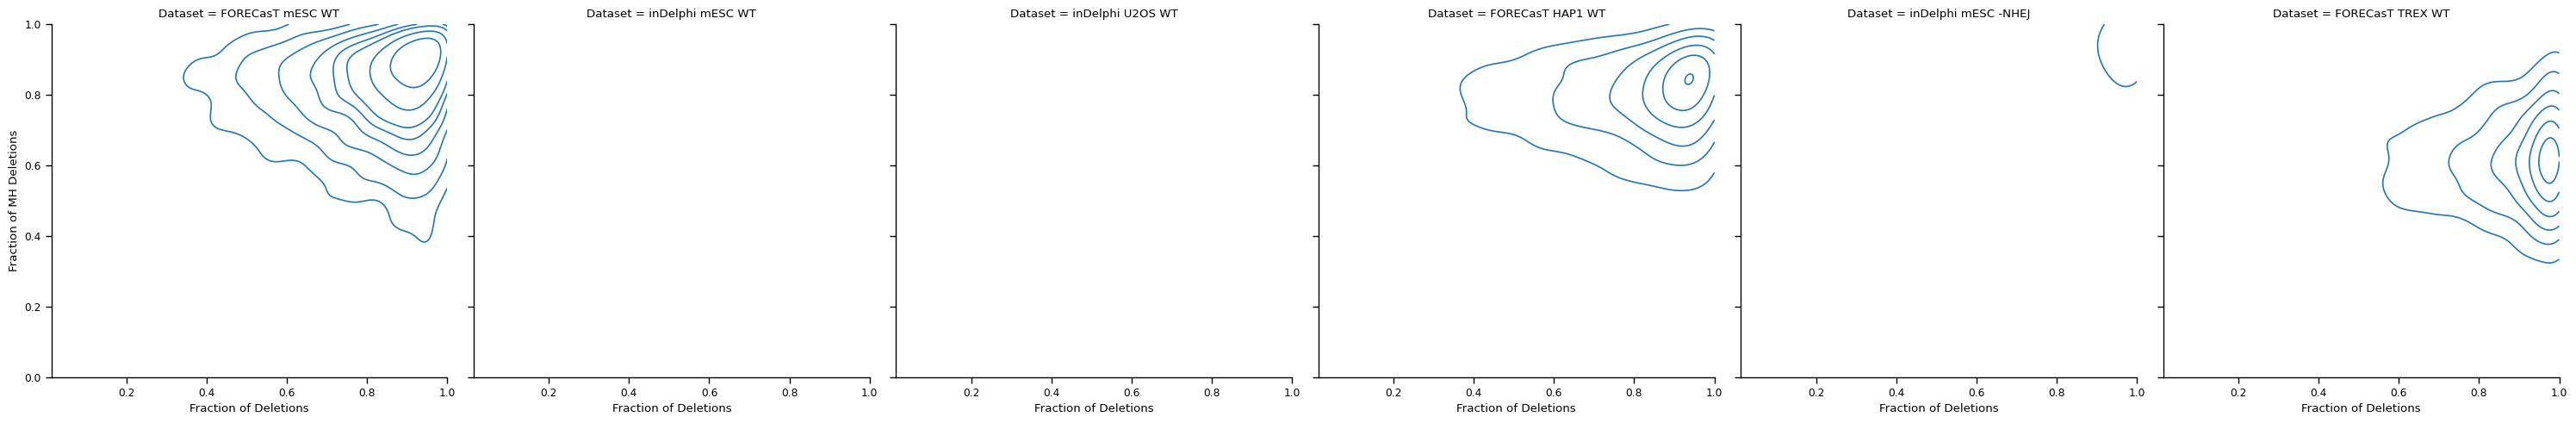

In [11]:
sns.displot(x="Fraction of Deletions", y="Fraction of MH Deletions", data=scatterplot_d, kind="kde", fill=False, cut=0, col="Dataset", thresh=0)

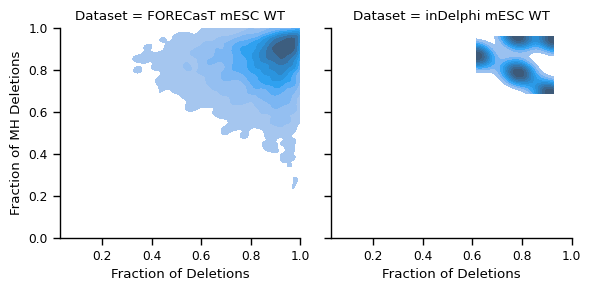

In [12]:
scatterplot_d1 = scatterplot_d[scatterplot_d["Dataset"].isin(["FORECasT mESC WT", "inDelphi mESC WT"])]
g = sns.FacetGrid(scatterplot_d1, col="Dataset")
g.map_dataframe(sns.kdeplot, x="Fraction of Deletions", y="Fraction of MH Deletions", fill=True, cut=0, bw_adjust=0.5)
axes = g.axes[0]
for a in axes:
    a.set_xlabel("Fraction of Deletions")
axes[0].set_ylabel("Fraction of MH Deletions")
plt.tight_layout()

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/3509277510.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d[["fraction", compare]].reset_index().groupby(["Sample_Name", compare]).sum()
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/3509277510.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d[["fraction", compare]].reset_index().groupby(["Sample_Name", compare]).sum()
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/3509277510.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, num

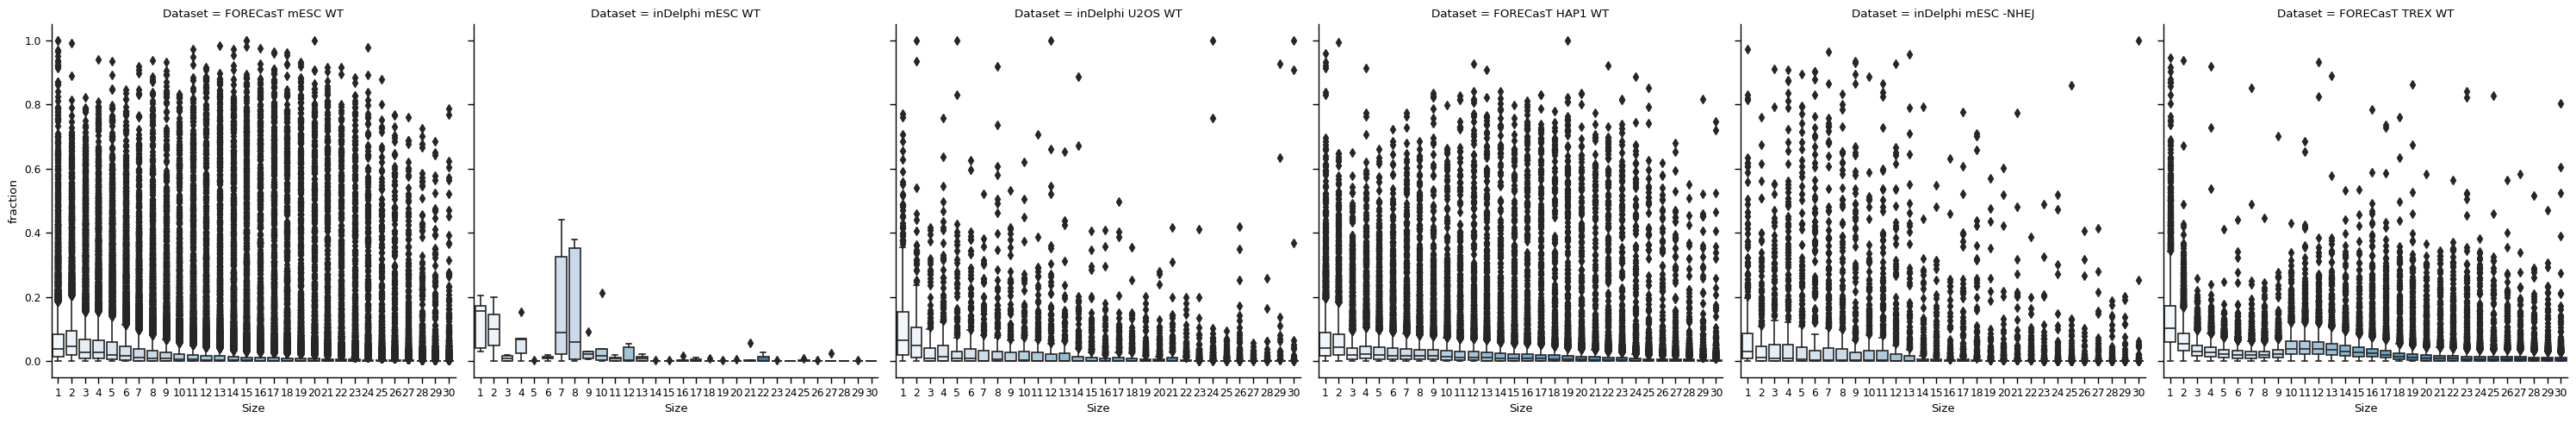

In [13]:
# plot deletion lengths

def plot_mh_deletion_lengths(counts, title, compare="Size"):
    c = []
    for i in range(len(counts)):
        a, b = counts[i]
        d = b.join(a, how="inner")[["homologyLength", "fraction", "Size"]]
        # d = d[d["homologyLength"] > 0]
        d = d[["fraction", compare]].reset_index().groupby(["Sample_Name", compare]).sum()
        d = d.reset_index()
        d["Dataset"] = title[i]
        c.append(d)
    c = pd.concat(c)
    return sns.catplot(data=c, x=compare, y="fraction", col="Dataset", kind="box", showfliers=True, palette="Blues")
    
del_len_p = plot_mh_deletion_lengths([(FORECasT_counts, FORECasT_features),\
    (WT, WT_features),\
    (U2OS, U2OS_features),\
    (HAP1, HAP1_features),\
    (NHEJ, NHEJ_features),\
    (TREX, TREX_features)],\
    ["FORECasT mESC WT", "inDelphi mESC WT", "inDelphi U2OS WT",\
    "FORECasT HAP1 WT", "inDelphi mESC -NHEJ", "FORECasT TREX WT"], compare="Size")

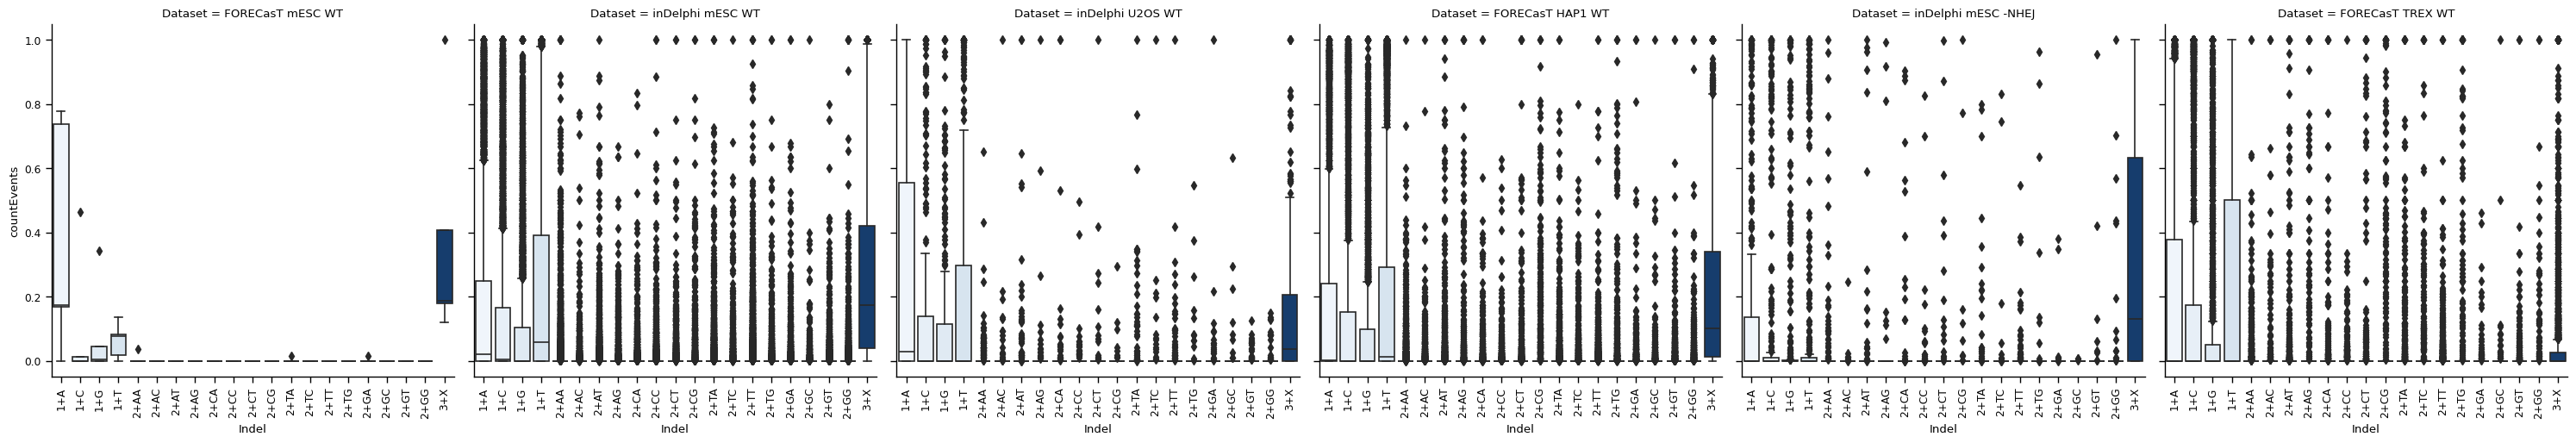

In [14]:
def plot_ins_predictions(counts, titles):
    ins_order = ["1+A", "1+C", "1+G", "1+T"]
    for nt in "ACTG":
        for nt2 in "ACTG":
            ins_order.append("2+" + nt + nt2)
    ins_order.append("3+X")
    for i in range(len(counts)):
        counts[i] = counts[i][counts[i]["Type"] == "INSERTION"][["countEvents"]]
        totals = counts[i].groupby(["Sample_Name"]).sum()
        counts[i] = counts[i][["countEvents"]].div(totals, axis=0, level=0)
        counts[i]["Dataset"] = titles[i]

    counts = pd.concat(counts)
    counts = counts.reset_index().set_index(["Dataset", "Sample_Name", "Indel"])

    g = sns.catplot(data=counts.reset_index(), y="countEvents", x="Indel", col="Dataset", kind="box", order=ins_order, showfliers=True, palette="Blues")
    g.set_xticklabels(rotation=90)
    return g
    
    
ins_p = plot_ins_predictions([WT, FORECasT_counts, U2OS, HAP1, NHEJ, TREX],  ["FORECasT mESC WT", "inDelphi mESC WT",\
    "inDelphi U2OS WT", "FORECasT HAP1 WT", "inDelphi mESC -NHEJ", "FORECasT TREX WT"])

/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/1920316749.py:117: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/1920316749.py:117: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/1920316749.py:117: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, n

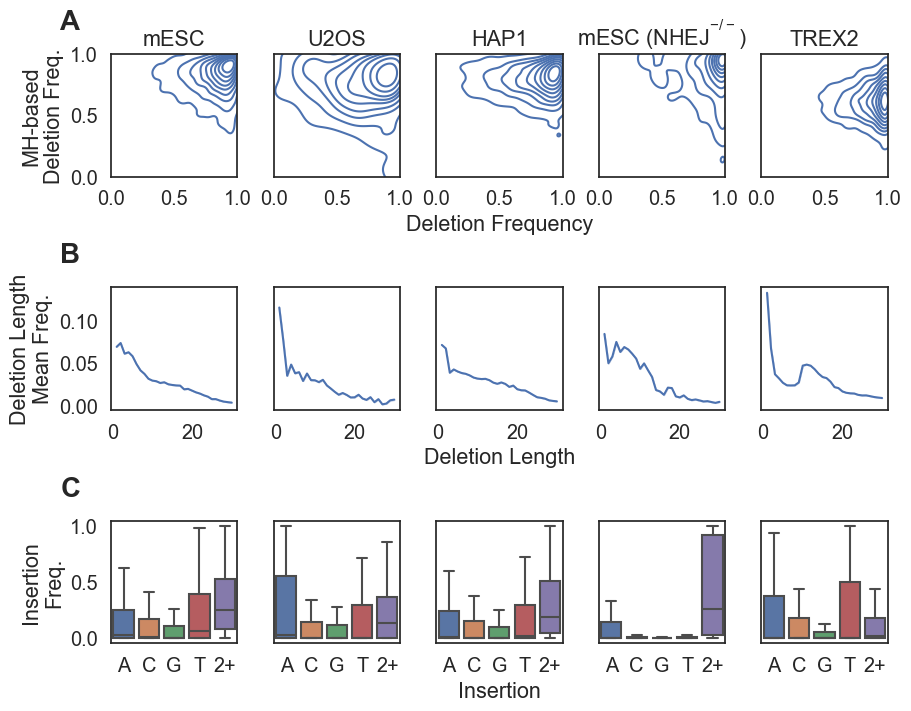

In [15]:
import numpy as np
import string

def plot_ins_predictions(counts, ax):
    ins_order = ["1+A", "1+C", "1+G", "1+T"]
    nt2s = []
    for nt in "ACTG":
        for nt2 in "ACTG":
            nt2s.append("2+" + nt + nt2)
    ins_order.append("2+X")
    # counts = counts.drop(nt2s, level=1, axis=0)
    counts = counts[counts["Type"] == "INSERTION"][["countEvents"]]

    totals = counts.groupby(["Sample_Name"]).sum()
    counts = counts[["countEvents"]].div(totals, axis=0, level=0)

    idx = pd.IndexSlice
    plus2_counts = counts.loc[idx[:,nt2s + ["3+X"]], :].groupby("Sample_Name").sum()
    plus2_counts["Indel"] = "2+X"
    plus2_counts.set_index("Indel", append=True, inplace=True)
    
    counts = pd.concat([counts, plus2_counts], axis=0)\
        .sort_index()\
        .drop(nt2s, level=1, axis=0)\
        .drop("3+X", level=1, axis=0)
    
    g = sns.boxplot(data=counts.reset_index(), y="countEvents", x="Indel", order=ins_order, showfliers=False, ax=ax)
    g.set_xticklabels(["A", "C", "G", "T", "2+"])
    return g

dataset_order =  ["FORECasT mESC WT",\
    "inDelphi U2OS WT", "FORECasT HAP1 WT", "inDelphi mESC -NHEJ", "FORECasT TREX WT"]

dataset_labels = {"FORECasT mESC WT": "mESC",
    "inDelphi U2OS WT": "U2OS",
    "FORECasT HAP1 WT": "HAP1",
    "inDelphi mESC -NHEJ": 'mESC ($\it{\mathregular{NHEJ^{-/-}}}$)',
    "FORECasT TREX WT": "TREX2"
    }
counts_and_features = [(FORECasT_counts, FORECasT_features),\
    (U2OS, U2OS_features),\
    (HAP1, HAP1_features),\
    (NHEJ, NHEJ_features),\
    (TREX, TREX_features)]


sns.set(font_scale=1.3)
sns.set_style("white")
plt.rcParams['text.usetex'] = False


# fig = plt.figure(figsize = (9, 7.5), constrained_layout = True)

# subfigs = fig.subfigures(nrows=3, ncols=1)

# subfigs[0].suptitle("A", x=0, fontsize=20, fontweight='bold', horizontalalignment='left')
# ax = subfigs[0].subplots(nrows=1, ncols=5, sharex=True, sharey=True)
# for i, d in enumerate(dataset_order):
#     g = sns.kdeplot(data=scatterplot_d[scatterplot_d["Dataset"] == d], x="Fraction of Deletions", y="Fraction of MH Deletions", \
#         ax=ax[i], levels=10, palette="Purples")
#     g.set_xlim((0,1))
#     g.set_ylim((0,1))
#     ax[i].set_title(dataset_labels[d])
#     ax[i].set_xlabel(None)
#     if i == 2:
#         ax[i].set_xlabel("Deletion Freq.")
# ax[0].set_ylabel("MH-based\nDeletion Freq.".format(d))


# subfigs[1].suptitle("B", x=0, fontsize=20, fontweight='bold', horizontalalignment='left')
# ax = subfigs[1].subplots(nrows=1, ncols=5, sharex=True, sharey=True)
# for i, title in enumerate(dataset_order):
#     a, b = counts_and_features[i]
#     d = b.join(a, how="inner")[["homologyLength", "fraction", "Size"]]
#     d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
#     d = d.reset_index()
#     d["Dataset"] = title
#     g = sns.lineplot(data=d, x="Size", y="fraction", ax=ax[i], estimator=np.mean, ci=0)
#     ax[i].set_ylabel(None)
#     ax[i].set_xlabel(None)
#     if i == 2:
#         ax[i].set_xlabel("Deletion Length")
# ax[0].set_ylabel("Deletion Length\nMean Freq.")

# subfigs[2].suptitle("C", x=0, fontsize=20, fontweight='bold', horizontalalignment='left')
# ax = subfigs[2].subplots(nrows=1, ncols=5, sharex=True, sharey=True)
# for i, title in enumerate(dataset_order):
#     plot_ins_predictions(counts_and_features[i][0], ax[i])
#     ax[i].set_ylabel(None)
#     ax[i].set_xlabel(None)
#     if i == 2:
#         ax[i].set_xlabel("Insertion")
# ax[0].set_ylabel("Insertion\nFreq.")

# plt.savefig("./artifacts/characterisation_box.pdf")
# plt.show()

fig, ax = plt.subplots(3, 5, figsize = (9, 7), sharey="row", sharex=False, constrained_layout = True)

for i, d in enumerate(dataset_order):
    g = sns.kdeplot(data=scatterplot_d[scatterplot_d["Dataset"] == d], x="Fraction of Deletions", y="Fraction of MH Deletions", \
        ax=ax[0,i], levels=10, palette="Purples")
    g.set_xlim((0,1))
    g.set_ylim((0,1))
    ax[0,i].set_title(dataset_labels[d])
    ax[0,i].set_xlabel(None)
    if i == 2:
        ax[0,i].set_xlabel("Deletion Frequency")

# ax[0,3].title.set_size(10)

ax[0,0].set_ylabel("MH-based\nDeletion Freq.".format(d))

for i, title in enumerate(dataset_order):
    a, b = counts_and_features[i]
    d = b.join(a, how="inner")[["homologyLength", "fraction", "Size"]]
    d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
    # d = d[["fraction", "Size"]].reset_index().groupby(["Size"]).median()
    d = d.reset_index()
    d["Dataset"] = title
    # g = sns.boxplot(data=d, y="Size", x="fraction", ax=ax[1,i], showfliers=False, palette="Purples", orient='h')
    g = sns.lineplot(data=d, x="Size", y="fraction", ax=ax[1,i], estimator=np.mean, ci=0)
    # ticklabels = [t if t in list(range(1,31,6)) else "" for t in range(1,31)]
    # ax[1, i].set_xticklabels(ticklabels)
    ax[1, i].set_ylabel(None)
    ax[1, i].set_xlabel(None)
    if i == 2:
        ax[1, i].set_xlabel("Deletion Length")
ax[1,0].set_ylabel("Deletion Length\nMean Freq.")

for i, title in enumerate(dataset_order):
    plot_ins_predictions(counts_and_features[i][0], ax[2,i])
    ax[2, i].set_ylabel(None)
    ax[2, i].set_xlabel(None)
    if i == 2:
        ax[2, i].set_xlabel("Insertion")
ax[2,0].set_ylabel("Insertion\nFreq.")

for i, a in enumerate(ax):
    for j, b in enumerate(a):
        if j > 0:
            b.set_ylabel("")

for n in range(3):
    ax[n, 0].text(-0.4, 1.2, string.ascii_uppercase[n], transform=ax[n, 0].transAxes, 
            size=20, weight='bold')

plt.subplots_adjust(wspace=0.1, hspace=0.025)
plt.savefig("./artifacts/characterisation_box.pdf", bbox_inches = 'tight')


/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/2179000022.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/2179000022.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
/var/folders/5x/n2td64g918lgvdh3qm2x3bhc0000gn/T/ipykernel_82898/2179000022.py:51: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, nume

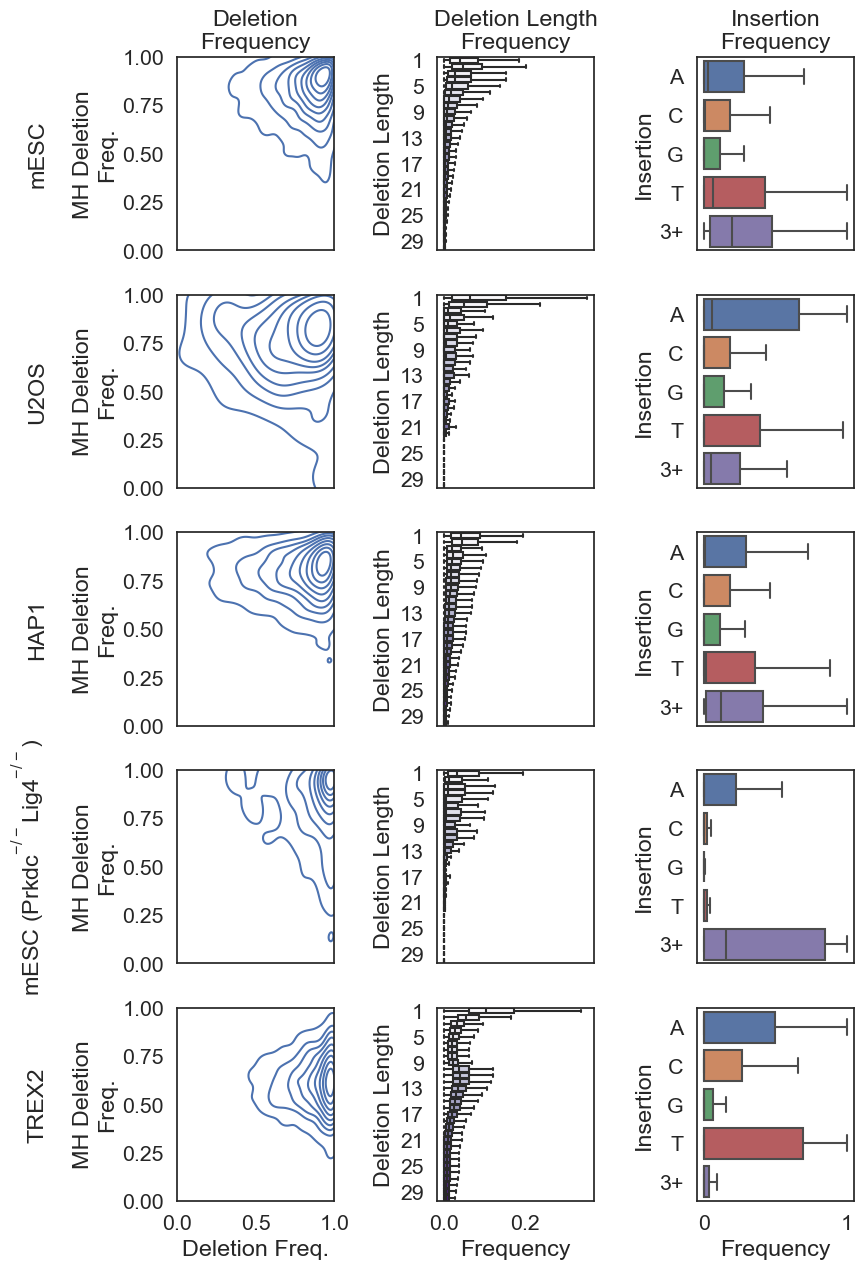

In [16]:
def plot_ins_predictions_vertical(counts, ax):
    ins_order = ["1+A", "1+C", "1+G", "1+T"]
    nt2s = []
    for nt in "ACTG":
        for nt2 in "ACTG":
            nt2s.append("2+" + nt + nt2)
    ins_order.append("3+X")
    counts = counts.drop(nt2s, level=1, axis=0)
    counts = counts[counts["Type"] == "INSERTION"][["countEvents"]]
    totals = counts.groupby(["Sample_Name"]).sum()
    counts = counts[["countEvents"]].div(totals, axis=0, level=0)

    g = sns.boxplot(data=counts.reset_index(), x="countEvents", y="Indel", order=ins_order, showfliers=False, ax=ax)
    g.set_yticklabels(["A", "C", "G", "T", "3+"])
    return g

dataset_order =  ["FORECasT mESC WT",\
    "inDelphi U2OS WT", "FORECasT HAP1 WT", "inDelphi mESC -NHEJ", "FORECasT TREX WT"]

dataset_labels = {"FORECasT mESC WT": "mESC",
    "inDelphi U2OS WT": "U2OS",
    "FORECasT HAP1 WT": "HAP1",
    "inDelphi mESC -NHEJ": 'mESC ($\it{\mathregular{Prkdc^{-/-}Lig4^{-/-}}}$)',
    "FORECasT TREX WT": "TREX2"
    }
counts_and_features = [(FORECasT_counts, FORECasT_features),\
    (U2OS, U2OS_features),\
    (HAP1, HAP1_features),\
    (NHEJ, NHEJ_features),\
    (TREX, TREX_features)]


sns.set(font_scale=1.4)
sns.set_style("white")
plt.rcParams['text.usetex'] = False

fig, ax = plt.subplots(5, 3, figsize = (9, 13), sharey=False, sharex="col")

for i, d in enumerate(dataset_order):
    g = sns.kdeplot(data=scatterplot_d[scatterplot_d["Dataset"] == d], x="Fraction of Deletions", y="Fraction of MH Deletions", ax=ax[i,0], levels=10, palette="Purples")
    g.set_xlim((0,1))
    g.set_ylim((0,1))
    g.set_xlabel("")
    ax[i,0].set_ylabel("{}\n\nMH Deletion\nFreq.".format(dataset_labels[d]))
    # ax[i,0].yaxis.set_tick_params(labelsize=10)
    # ax[i,0].xaxis.set_tick_params(labelsize=10)

for i, title in enumerate(dataset_order):
    a, b = counts_and_features[i]
    d = b.join(a, how="inner")[["homologyLength", "fraction", "Size"]]
    d = d[["fraction", "Size"]].reset_index().groupby(["Sample_Name", "Size"]).sum()
    d = d.reset_index()
    d["Dataset"] = title
    g = sns.boxplot(data=d, y="Size", x="fraction", ax=ax[i,1], showfliers=False, palette="Purples", orient='h')

    ticklabels = [t if t in list(range(1,31,4)) else "" for t in range(1,31)]
    ax[i,1].set_yticklabels(ticklabels)
    ax[i,1].xaxis.set_tick_params()
    ax[i,1].set_ylabel("Deletion Length")
    ax[i,1].set_xlabel("")

for i, title in enumerate(dataset_order):
    plot_ins_predictions_vertical(counts_and_features[i][0], ax[i,2])
    ax[i,2].set_xlabel("")
    ax[i,2].set_ylabel("Insertion")
    # ax[i,2].yaxis.set_tick_params(labelsize=10)
    # ax[i,2].xaxis.set_tick_params(labelsize=10)

ax[0,0].set_title("Deletion\nFrequency")
ax[0,1].set_title("Deletion Length\nFrequency")
ax[0,2].set_title("Insertion\nFrequency")

ax[4,0].set_xlabel("Deletion Freq.")
ax[4,1].set_xlabel("Frequency")
ax[4,2].set_xlabel("Frequency")

plt.tight_layout()
plt.savefig("./artifacts/characterisation_box_vertical.pdf", facecolor="white")
    